# Chron.jl demo
This Jupyter notebook demonstrates the [Chron.jl](https://github.com/brenhinkeller/Chron.jl) Julia package for integrated Bayesian eruption age and stratigraphic age-depth modelling, based in part on the work of [Keller, Schoene, and Sameperton (2018)](https://doi.org/10.7185/geochemlet.1826) Geochemical Perspectives Letters 8, 31-35

Any code from this notebook can also be copied and pasted into the Julia REPL or a .jl script

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file
***
## Load external resources

In [1]:
# Load (and install if necessary) the Chron.jl package
if VERSION>=v"0.7"
    using Pkg, Statistics
end

try
    using Chron
catch
    Pkg.clone("https://github.com/brenhinkeller/Chron.jl")
    using Chron
end

using Plots; gr(); default(fmt = :png)

## Enter sample information
This example data is from Clyde et al. (2016) "Direct high-precision
U–Pb geochronology of the end-Cretaceous extinction and calibration of
Paleocene astronomical timescales" EPSL 452, 272–280.
doi: 10.1016/j.epsl.2016.07.041

In [2]:
nSamples = 5 # The number of samples you have data for
smpl = NewStratAgeData(nSamples)
smpl.Name      =   ("KJ08-157", "KJ04-75", "KJ09-66", "KJ04-72", "KJ04-70",)
smpl.Height[:] =   [     -52.0,      44.0,      54.0,      82.0,      93.0,]
smpl.Height_Sigma[:] = [   3.0,       1.0,       3.0,       3.0,       3.0,]
smpl.Age_Sidedness[:] = zeros(nSamples) # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Path = "DenverUPbExampleData/" # Where are the data files?
smpl.inputSigmaLevel = 2 # i.e., are the data files 1-sigma or 2-sigma. Integer.

AgeUnit = "Ma" # Unit of measurement for ages and errors in the data files
HeightUnit = "cm"; # Unit of measurement for Height and Height_Sigma

## Configure and run eruption/deposition age model
To learn more about the eruption/deposition age estimation model, see also [Keller, Schoene, and Sameperton (2018)](https://doi.org/10.7185/geochemlet.1826) and the [BayeZirChron demo notebook](http://brenh.in/BayeZirChron)

In [3]:
# Number of steps to run in distribution MCMC
distSteps = 10^6
distBurnin = floor(Int,distSteps/100)

# Choose the form of the prior distribution to use. 
# A variety of potentially useful distributions are provided in DistMetropolis.jl - Options include UniformDisribution,
# TriangularDistribution, BootstrappedDistribution, and MeltsVolcanicZirconDistribution - or you can define your own.
dist = TriangularDistribution;

# Run MCMC to estimate saturation and eruption/deposition age distributions
smpl = tMinDistMetropolis(smpl,distSteps,distBurnin,dist);

Estimating eruption/deposition age distributions...
1: KJ08-157
2: KJ04-75
3: KJ09-66
4: KJ04-72
5: KJ04-70


In [4]:
# Let's see what that did
run(`ls $(smpl.Path)`); sleep(1)

KJ04-70.csv
KJ04-70_distribution.pdf
KJ04-70_rankorder.pdf
KJ04-72.csv
KJ04-72_distribution.pdf
KJ04-72_rankorder.pdf
KJ04-75.csv
KJ04-75_distribution.pdf
KJ04-75_rankorder.pdf
KJ08-157.csv
KJ08-157_distribution.pdf
KJ08-157_rankorder.pdf
KJ09-66.csv
KJ09-66_distribution.pdf
KJ09-66_rankorder.pdf
KJ12-01.csv
results.csv


To see what one of these plots looks like, try pasting this into a markdown cell like the one below
```
<img src="DenverUPbExampleData/KJ04-75_rankorder.pdf" align="left"/>
```

For each sample, the eruption/deposition age distribution is inherently asymmetric. For example:
<img src="DenverUPbExampleData/KJ04-70_distribution.pdf" align="left"/>

Consequently, rather than simply taking a mean and standard deviation of the stationary distribtuion of the Markov Chain, the histogram of the stationary distribution is fit to an empirical distribution function of the form 

$$ f = a * \exp\left(d^2e^2\frac{x - b}{c}\left(\frac{1}{2} - \frac{atan\left(\frac{x - b}{c}\right)}{\pi}\right)  - \frac{d^2}{e^2}\frac{x - b}{c}\left(\frac{1}{2} + \frac{atan\left(\frac{x - b}{c}\right)}{\pi}\right)\right) $$ 

i.e., an asymmetric exponential function with two log-linear segments joined with an arctangent sigmoid. After fitting, the five parameters $a$ - $e$ are stored in `smpl.params` and passed to the stratigraphic model



## Configure and run stratigraphic model
note: to spare Binder's servers, this demo uses
```
config.nsteps = 3000 
config.burnin = 2000*npoints_approx
```
However, you probably want higher numbers for a publication-quality result, for instance 
```
config.nsteps = 15000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
```

In [5]:
# Configure the stratigraphic Monte Carlo model
config = NewStratAgeModelConfiguration()
# If you in doubt, you can probably leave these parameters as-is
config.resolution = 1.0 # Same units as sample height. Smaller is slower!
config.bounding = 0.1 # how far away do we place runaway bounds, as a fraction of total section height
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 3000 # Number of steps to run in distribution MCMC
config.burnin = 2000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps

# Run the stratigraphic MCMC model
(mdl, agedist, lldist) = StratMetropolisDist(smpl, config);

Generating stratigraphic age-depth model...
Burn-in: 350000 steps


Burn-in... 97%|████████████████████████████████████████ |  ETA: 0:00:03

Burn-in...100%|█████████████████████████████████████████| Time: 0:01:40
Collecting... 93%|███████████████████████████████████   |  ETA: 0:00:10

(Chron.StratAgeModel([-51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5  …  83.5, 84.5, 85.5, 86.5, 87.5, 88.5, 89.5, 90.5, 91.5, 92.5], [66.0691, 66.0681, 66.067, 66.0658, 66.0648, 66.0636, 66.0626, 66.0615, 66.0604, 66.0594  …  65.9146, 65.9107, 65.9063, 65.902, 65.8977, 65.8931, 65.8888, 65.8851, 65.8812, 65.8776], [0.0117851, 0.0124041, 0.0130692, 0.0137776, 0.0142413, 0.0149503, 0.0155074, 0.0161814, 0.0165959, 0.0169855  …  0.0237311, 0.0242499, 0.0242225, 0.0243929, 0.023966, 0.0235348, 0.02307, 0.0223431, 0.021307, 0.0202289], [66.0709, 66.0699, 66.0689, 66.0678, 66.0668, 66.0659, 66.065, 66.0641, 66.0629, 66.0619  …  65.9163, 65.912, 65.9071, 65.9016, 65.8968, 65.8918, 65.887, 65.8834, 65.8797, 65.8768], [66.0418, 66.0396, 66.0368, 66.0324, 66.0301, 66.0277, 66.0263, 66.0228, 66.0214, 66.0196  …  65.865, 65.8618, 65.8583, 65.8557, 65.8529, 65.8493, 65.8466, 65.8455, 65.842, 65.8399], [66.0858, 66.0857, 66.0855, 66.0854, 66.0852, 66.0851, 66.085, 66.0847, 66.

Collecting...100%|██████████████████████████████████████| Time: 0:02:14


## Plot results

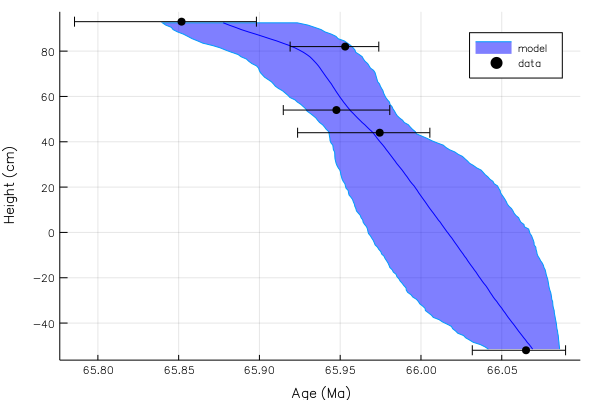

In [6]:
# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(minimum(mdl.Height),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="")
plot!(hdl, smpl.Age, smpl.Height, xerror=(smpl.Age-smpl.Age_025CI,smpl.Age_975CI-smpl.Age),label="data",seriestype=:scatter,color=:black)
plot!(hdl, xlabel="Age ($AgeUnit)", ylabel="Height ($HeightUnit)")
savefig(hdl,"AgeDepthModel.pdf");
display(hdl)

In [7]:
# Interpolate results at KTB (height = 0)
KTB = linterp1s(mdl.Height,mdl.Age,0)
KTB_min = linterp1s(mdl.Height,mdl.Age_025CI,0)
KTB_max = linterp1s(mdl.Height,mdl.Age_975CI,0)
print("Interpolated age: $KTB +$(KTB_max-KTB)/-$(KTB-KTB_min) Ma")

Interpolated age: 66.01642354068589 +0.05088381998432112/-0.04909590322155566 Ma